In [ ]:
from tools.utils import *
from tools.het_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# Random
seed = 42

# Model
hidden_channels = 128
num_layers = 2
intra_aggr='sum'
inter_aggr='mean'
dropout = 0.5

# Training
batch_size = 8
epochs = 15
lr = 1e-4
maxlr = 1e-3

# Preprocessing

In [35]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [36]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [41]:
# Construct het dataset
het_dataset = []
for hom_data in normalized_hom_dataset_attr:
    het_data = convert_hom_to_het(hom_data, onehot_indices=[18, 19, 20], is_directed=False)
    het_dataset.append(het_data)
het_dataset.__len__()

600

In [42]:
# Get the metadata to build HeteroGNN
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)
metadata

(['A', 'B', 'C'],
 [('A', 'edge_index', 'A'),
  ('A', 'edge_index', 'B'),
  ('A', 'edge_index', 'C'),
  ('B', 'edge_index', 'B'),
  ('B', 'edge_index', 'C'),
  ('C', 'edge_index', 'C')])

In [44]:
# Construct data loaders
labels = [data.y.item() for data in het_dataset]
train_set, temp_set = train_test_split(het_dataset, test_size=0.3, stratify=labels, random_state=seed)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(temp_set, test_size=0.5, stratify=temp_labels, random_state=seed)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# GraphConv

In [ ]:
experiment_name = f"HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

model = HeteroGNN_GraphConv(metadata, hidden_channels, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

ModuleDict(
  (<A___edge_index___A>): GraphConv((-1, -1), 256)
  (<A___edge_index___B>): GraphConv((-1, -1), 256)
  (<A___edge_index___C>): GraphConv((-1, -1), 256)
  (<B___edge_index___B>): GraphConv((-1, -1), 256)
  (<B___edge_index___C>): GraphConv((-1, -1), 256)
  (<C___edge_index___C>): GraphConv((-1, -1), 256)
)

In [ ]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [ ]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, test_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 2.3032 | Valid Loss: 1.7695
Train Acc: 0.2238 | Valid Acc: 0.2444
Train F1: 0.1004 | Valid F1: 0.1876

Epoch 2/30
Train Loss: 1.7815 | Valid Loss: 1.7858
Train Acc: 0.2476 | Valid Acc: 0.2556
Train F1: 0.2456 | Valid F1: 0.2348

Epoch 3/30
Train Loss: 1.7451 | Valid Loss: 1.7867
Train Acc: 0.2714 | Valid Acc: 0.2556
Train F1: 0.2730 | Valid F1: 0.2315

Epoch 4/30
Train Loss: 1.7284 | Valid Loss: 1.8195
Train Acc: 0.2714 | Valid Acc: 0.2444
Train F1: 0.2681 | Valid F1: 0.2123

Epoch 5/30
Train Loss: 1.7217 | Valid Loss: 1.7960
Train Acc: 0.2690 | Valid Acc: 0.2778
Train F1: 0.2701 | Valid F1: 0.2379

Epoch 6/30
Train Loss: 1.6850 | Valid Loss: 1.8449
Train Acc: 0.3143 | Valid Acc: 0.2444
Train F1: 0.3093 | Valid F1: 0.1810

Epoch 7/30
Train Loss: 1.7059 | Valid Loss: 1.7978
Train Acc: 0.2762 | Valid Acc: 0.3111
Train F1: 0.2627 | Valid F1: 0.3017

Epoch 8/30
Train Loss: 1.7310 | Valid Loss: 1.7907
Train Acc: 0.2619 | Valid Acc: 0.2889
Train F1: 0.2627 | Valid F1: 

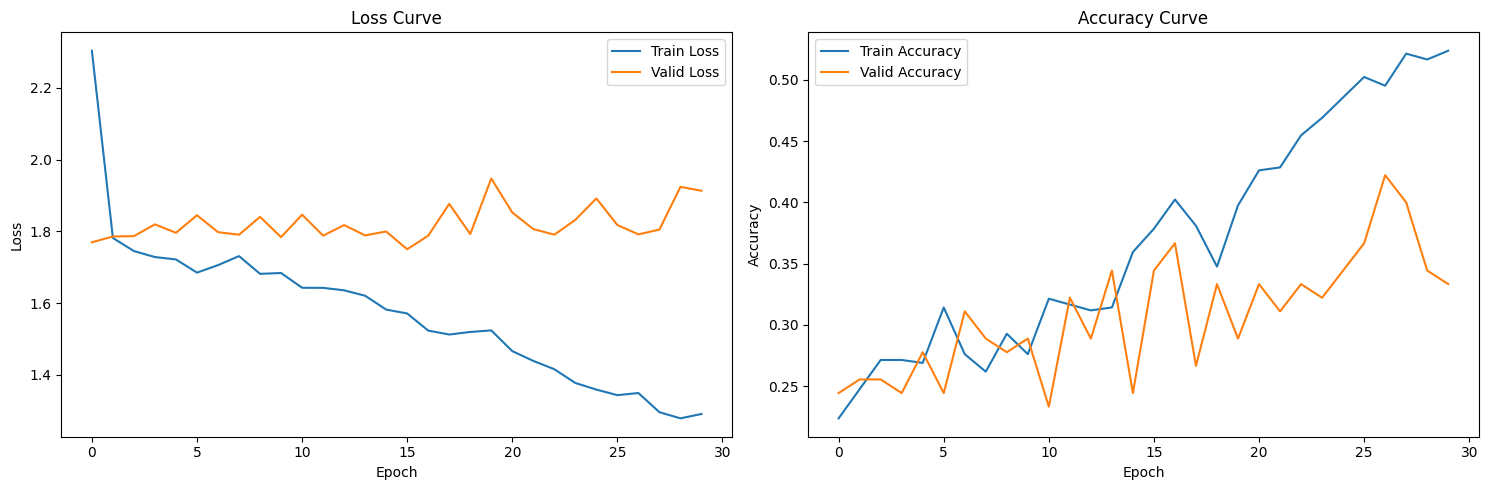

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,2.3032,1.7695,0.2238,0.2444,0.1004,0.1876
1,2,1.7815,1.7858,0.2476,0.2556,0.2456,0.2348
2,3,1.7451,1.7867,0.2714,0.2556,0.2730,0.2315
3,4,1.7284,1.8195,0.2714,0.2444,0.2681,0.2123
4,5,1.7217,1.7960,0.2690,0.2778,0.2701,0.2379
5,6,1.6850,1.8449,0.3143,0.2444,0.3093,0.1810
6,7,1.7059,1.7978,0.2762,0.3111,0.2627,0.3017
7,8,1.7310,1.7907,0.2619,0.2889,0.2627,0.2618
8,9,1.6816,1.8404,0.2929,0.2778,0.2771,0.1939
9,10,1.6840,1.7839,0.2762,0.2889,0.2762,0.2341


In [ ]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# SAGEConv

In [ ]:
experiment_name = f"HeteroGNN_SAGEConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

model = HeteroGNN_SAGEConv(metadata, hidden_channels, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

ModuleDict(
  (<A___edge_index___A>): SAGEConv((-1, -1), 256, aggr=mean)
  (<A___edge_index___B>): SAGEConv((-1, -1), 256, aggr=mean)
  (<A___edge_index___C>): SAGEConv((-1, -1), 256, aggr=mean)
  (<B___edge_index___B>): SAGEConv((-1, -1), 256, aggr=mean)
  (<B___edge_index___C>): SAGEConv((-1, -1), 256, aggr=mean)
  (<C___edge_index___C>): SAGEConv((-1, -1), 256, aggr=mean)
)

In [ ]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [ ]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, test_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 2.2726 | Valid Loss: 1.7413
Train Acc: 0.2381 | Valid Acc: 0.2889
Train F1: 0.0926 | Valid F1: 0.2363

Epoch 2/30
Train Loss: 1.7887 | Valid Loss: 1.7783
Train Acc: 0.2738 | Valid Acc: 0.3222
Train F1: 0.2711 | Valid F1: 0.2661

Epoch 3/30
Train Loss: 1.7224 | Valid Loss: 1.7796
Train Acc: 0.2643 | Valid Acc: 0.3222
Train F1: 0.2676 | Valid F1: 0.2661

Epoch 4/30
Train Loss: 1.7205 | Valid Loss: 1.7813
Train Acc: 0.2738 | Valid Acc: 0.3222
Train F1: 0.2716 | Valid F1: 0.2651

Epoch 5/30
Train Loss: 1.7259 | Valid Loss: 1.7922
Train Acc: 0.2833 | Valid Acc: 0.2889
Train F1: 0.2769 | Valid F1: 0.2679

Epoch 6/30
Train Loss: 1.7129 | Valid Loss: 1.7745
Train Acc: 0.2786 | Valid Acc: 0.2889
Train F1: 0.2853 | Valid F1: 0.2552

Epoch 7/30
Train Loss: 1.7077 | Valid Loss: 1.7719
Train Acc: 0.2524 | Valid Acc: 0.2889
Train F1: 0.2486 | Valid F1: 0.2374

Epoch 8/30
Train Loss: 1.6760 | Valid Loss: 1.7797
Train Acc: 0.2857 | Valid Acc: 0.2889
Train F1: 0.2817 | Valid F1: 

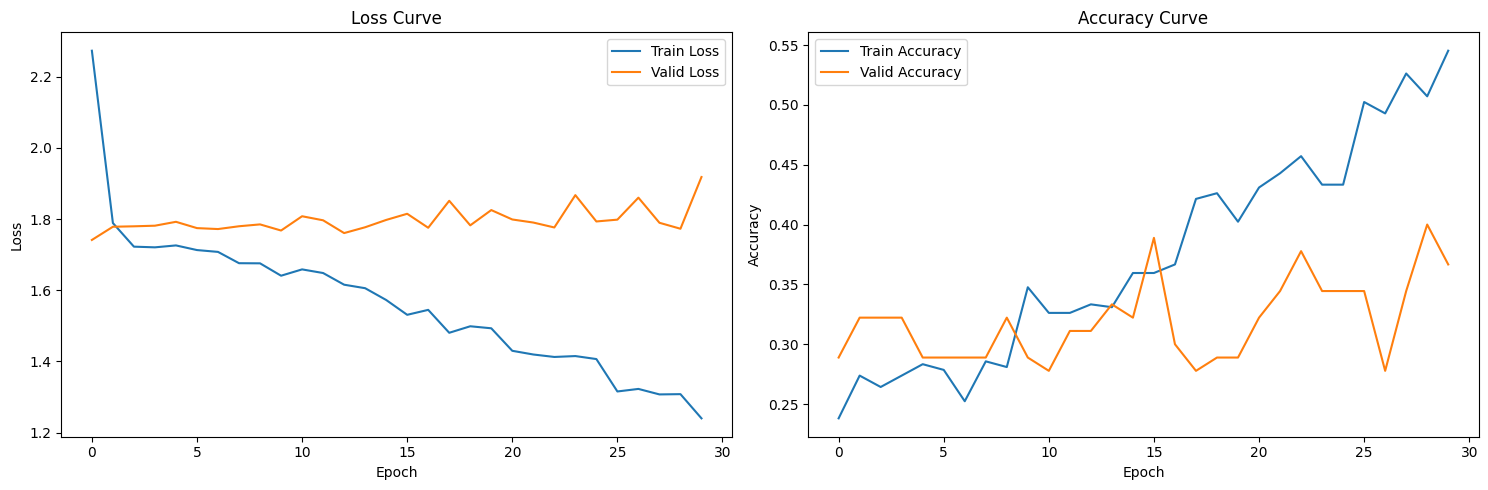

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,2.2726,1.7413,0.2381,0.2889,0.0926,0.2363
1,2,1.7887,1.7783,0.2738,0.3222,0.2711,0.2661
2,3,1.7224,1.7796,0.2643,0.3222,0.2676,0.2661
3,4,1.7205,1.7813,0.2738,0.3222,0.2716,0.2651
4,5,1.7259,1.7922,0.2833,0.2889,0.2769,0.2679
5,6,1.7129,1.7745,0.2786,0.2889,0.2853,0.2552
6,7,1.7077,1.7719,0.2524,0.2889,0.2486,0.2374
7,8,1.6760,1.7797,0.2857,0.2889,0.2817,0.2469
8,9,1.6756,1.7850,0.2810,0.3222,0.2835,0.2840
9,10,1.6409,1.7677,0.3476,0.2889,0.3402,0.2580


In [ ]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# GATConv

In [ ]:
experiment_name = f"HeteroGNN_GATConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

model = HeteroGNN_GATConv(metadata, hidden_channels, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

ModuleDict(
  (<A___edge_index___A>): GATConv((-1, -1), 256, heads=1)
  (<A___edge_index___B>): GATConv((-1, -1), 256, heads=1)
  (<A___edge_index___C>): GATConv((-1, -1), 256, heads=1)
  (<B___edge_index___B>): GATConv((-1, -1), 256, heads=1)
  (<B___edge_index___C>): GATConv((-1, -1), 256, heads=1)
  (<C___edge_index___C>): GATConv((-1, -1), 256, heads=1)
)

In [ ]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [ ]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, test_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 2.3355 | Valid Loss: 1.7776
Train Acc: 0.2357 | Valid Acc: 0.2667
Train F1: 0.1120 | Valid F1: 0.2364

Epoch 2/30
Train Loss: 1.7615 | Valid Loss: 1.7475
Train Acc: 0.2690 | Valid Acc: 0.3000
Train F1: 0.2674 | Valid F1: 0.2528

Epoch 3/30
Train Loss: 1.7517 | Valid Loss: 1.7750
Train Acc: 0.2667 | Valid Acc: 0.2444
Train F1: 0.2569 | Valid F1: 0.1937

Epoch 4/30
Train Loss: 1.7232 | Valid Loss: 1.7649
Train Acc: 0.2619 | Valid Acc: 0.3000
Train F1: 0.2666 | Valid F1: 0.2492

Epoch 5/30
Train Loss: 1.7105 | Valid Loss: 1.8279
Train Acc: 0.3071 | Valid Acc: 0.2778
Train F1: 0.2959 | Valid F1: 0.2062

Epoch 6/30
Train Loss: 1.7223 | Valid Loss: 1.7741
Train Acc: 0.2810 | Valid Acc: 0.2667
Train F1: 0.2735 | Valid F1: 0.2411

Epoch 7/30
Train Loss: 1.7055 | Valid Loss: 1.7992
Train Acc: 0.2667 | Valid Acc: 0.3000
Train F1: 0.2690 | Valid F1: 0.2534

Epoch 8/30
Train Loss: 1.6705 | Valid Loss: 1.7644
Train Acc: 0.3238 | Valid Acc: 0.3222
Train F1: 0.3155 | Valid F1: 

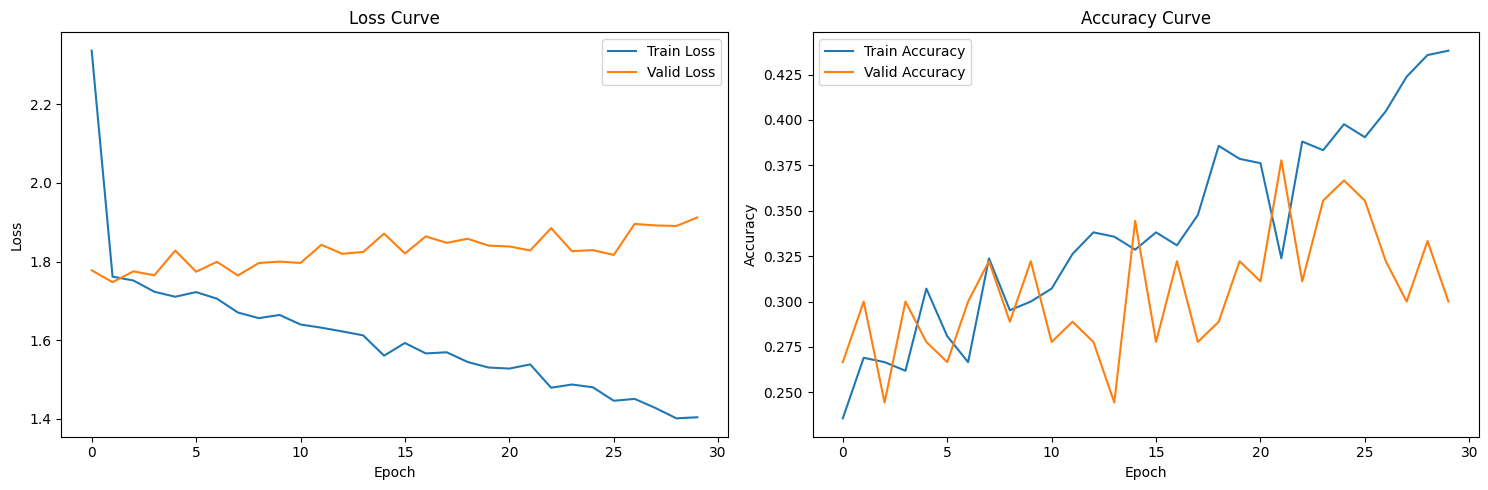

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,2.3355,1.7776,0.2357,0.2667,0.1120,0.2364
1,2,1.7615,1.7475,0.2690,0.3000,0.2674,0.2528
2,3,1.7517,1.7750,0.2667,0.2444,0.2569,0.1937
3,4,1.7232,1.7649,0.2619,0.3000,0.2666,0.2492
4,5,1.7105,1.8279,0.3071,0.2778,0.2959,0.2062
5,6,1.7223,1.7741,0.2810,0.2667,0.2735,0.2411
6,7,1.7055,1.7992,0.2667,0.3000,0.2690,0.2534
7,8,1.6705,1.7644,0.3238,0.3222,0.3155,0.2652
8,9,1.6561,1.7960,0.2952,0.2889,0.2958,0.2335
9,10,1.6642,1.7997,0.3000,0.3222,0.2795,0.2776


In [ ]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)